## Import Data ##

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [12]:
from torch_geometric.datasets import WikiCS

dataset = WikiCS(root="/tmp/WikiCS")
data = dataset[0]

num_samples = data.num_nodes
train_mask = torch.zeros(num_samples, dtype=torch.bool)
val_mask = torch.zeros(num_samples, dtype=torch.bool)
test_mask = torch.zeros(num_samples, dtype=torch.bool)

train_mask[:int(0.8 * num_samples)] = 1
val_mask[int(0.8 * num_samples):int(0.9 * num_samples)] = 1
test_mask[int(0.9 * num_samples):] = 1

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

## Statistical Modeling ##

In [14]:
pd_data = pd.DataFrame(data.x.cpu().numpy())

In [16]:
pd_data.shape

(11701, 300)

In [18]:
pd_data.head(20).corr()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.000000,0.116015,-0.252161,0.062595,0.200589,-0.044918,-0.072477,0.068631,-0.105087,0.162715,...,0.011344,0.292728,0.103648,-0.190974,-0.267481,-0.084978,0.380261,0.084694,-0.045776,0.407430
1,0.116015,1.000000,-0.372819,0.242140,-0.423464,-0.622376,-0.597134,-0.096146,0.001678,0.431800,...,0.076220,0.468007,-0.148315,-0.734751,0.211447,0.245046,0.371934,0.141328,-0.170404,0.207328
2,-0.252161,-0.372819,1.000000,-0.424173,0.187706,0.282029,0.161428,-0.268593,0.332860,-0.437708,...,-0.485594,-0.099084,0.491031,0.461884,-0.461204,-0.552742,-0.160370,0.453808,0.117484,-0.340824
3,0.062595,0.242140,-0.424173,1.000000,0.261869,0.215162,0.327607,0.017133,-0.199526,-0.158986,...,0.563952,-0.376604,-0.026428,-0.171222,0.101351,-0.075898,-0.261301,-0.493148,-0.080410,0.256321
4,0.200589,-0.423464,0.187706,0.261869,1.000000,0.387581,0.439297,-0.080278,-0.172603,-0.432507,...,0.232155,-0.640906,0.141611,0.144955,-0.152210,-0.302826,-0.220320,-0.209960,0.206995,-0.008302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.084978,0.245046,-0.552742,-0.075898,-0.302826,-0.452944,-0.463852,0.300521,-0.477531,0.335415,...,0.373164,0.105912,-0.461238,-0.539456,0.174412,1.000000,0.172610,-0.086428,0.020132,0.056171
296,0.380261,0.371934,-0.160370,-0.261301,-0.220320,-0.750490,-0.325993,-0.060560,-0.028609,0.432961,...,-0.275162,0.481622,-0.350302,-0.433656,0.206573,0.172610,1.000000,0.082617,-0.364658,0.517720
297,0.084694,0.141328,0.453808,-0.493148,-0.209960,-0.047278,-0.369956,-0.051265,-0.017981,0.013588,...,-0.555926,0.132721,0.160494,-0.025804,-0.232604,-0.086428,0.082617,1.000000,0.073660,-0.030802
298,-0.045776,-0.170404,0.117484,-0.080410,0.206995,0.501625,0.104013,-0.363233,0.171408,0.006904,...,-0.170220,-0.250978,0.322403,-0.104249,-0.159675,0.020132,-0.364658,0.073660,1.000000,-0.599815


In [20]:
pd_data.head(20).describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.047702,0.009369,-0.000586,-0.012862,-0.012615,0.087510,0.044134,-0.090211,0.079058,1.270245,...,-0.178917,0.043303,-0.002813,0.158838,0.012520,-0.129649,-0.035813,-0.046148,-0.021510,0.090545
std,0.065925,0.102479,0.085837,0.038466,0.057640,0.113941,0.050735,0.087572,0.058739,0.188999,...,0.072936,0.061281,0.070558,0.071791,0.053875,0.082146,0.077617,0.071945,0.069702,0.075152
min,-0.153400,-0.154400,-0.149702,-0.083867,-0.106689,-0.058403,-0.067510,-0.230116,-0.043524,0.939040,...,-0.313806,-0.115051,-0.104564,0.039066,-0.115574,-0.320349,-0.243703,-0.141123,-0.157389,-0.058781
25%,-0.107738,-0.063135,-0.054985,-0.050229,-0.048805,0.014403,0.005139,-0.136748,0.056561,1.158584,...,-0.229385,0.020442,-0.043537,0.127643,-0.016724,-0.181493,-0.088319,-0.085976,-0.073160,0.042179
50%,-0.045825,0.013022,-0.012059,-0.004900,-0.025965,0.064305,0.042308,-0.104142,0.083500,1.224893,...,-0.177175,0.050511,-0.034096,0.151679,0.010261,-0.140537,-0.032869,-0.051495,-0.015589,0.094401
75%,-0.016814,0.064685,0.061663,0.012273,0.034844,0.124574,0.078665,-0.040151,0.118560,1.406281,...,-0.113258,0.092178,0.035369,0.194656,0.057380,-0.073143,0.008031,-0.022066,0.019252,0.143508
max,0.094374,0.259460,0.150925,0.047091,0.097766,0.454006,0.131720,0.100125,0.166949,1.618930,...,-0.067529,0.125526,0.195385,0.325731,0.104625,0.019142,0.085870,0.139847,0.142077,0.244536


In [22]:
def data_to_nx_subgraph(data, node_range):
    G = nx.Graph()
    
    start, end = node_range
    G.add_nodes_from(range(start, end))

    edge_index = data.edge_index
    edges = edge_index.t().tolist()

    filtered_edges = [
        (u, v) for u, v in edges if u >= start and u < end and v >= start and v < end
    ]

    G.add_edges_from(filtered_edges)
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

node_range = (0, 500)
G = data_to_nx_subgraph(data, node_range)

In [24]:
nx.cluster.average_clustering(G)

0.3904619978752118

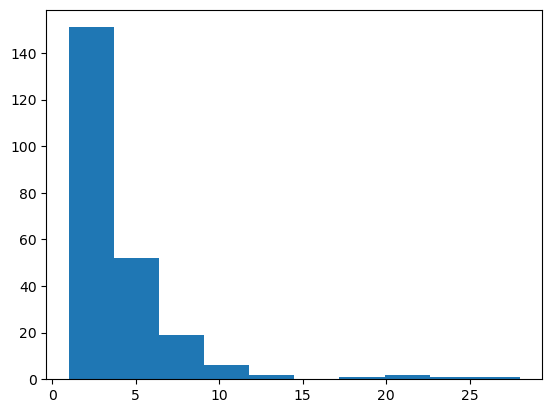

In [26]:
plt.hist([v for k, v in nx.degree(G)]);

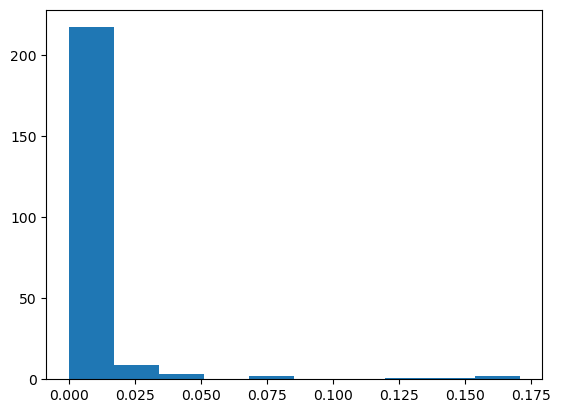

In [28]:
plt.hist(nx.centrality.betweenness_centrality(G).values());

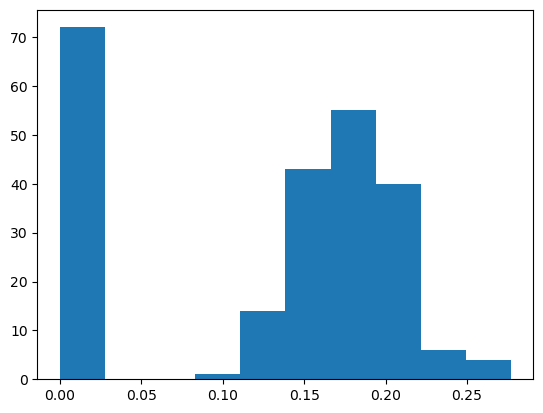

In [30]:
plt.hist(nx.centrality.closeness_centrality(G).values());

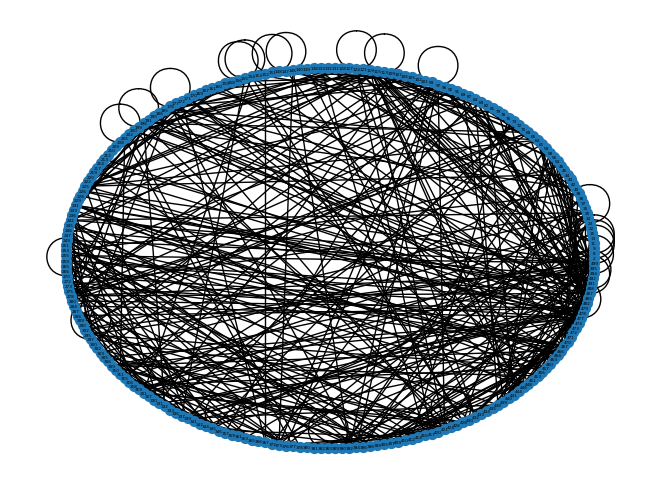

In [32]:
nx.draw_circular(G, with_labels=True, node_size=50, font_size=3)
plt.show()

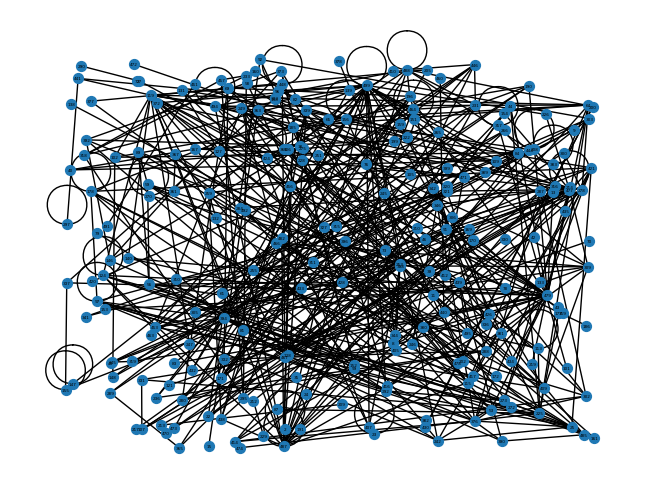

In [34]:
nx.draw_random(G, with_labels=True, node_size=50, font_size=3)
plt.show()

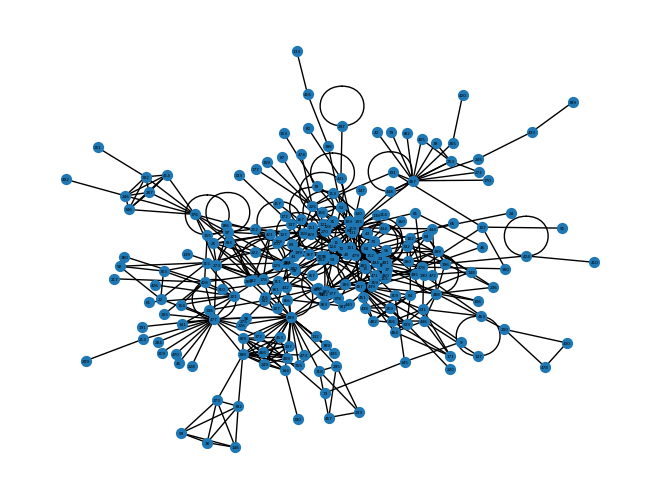

In [36]:
nx.draw_kamada_kawai(G, with_labels=True, node_size=50, font_size=3)

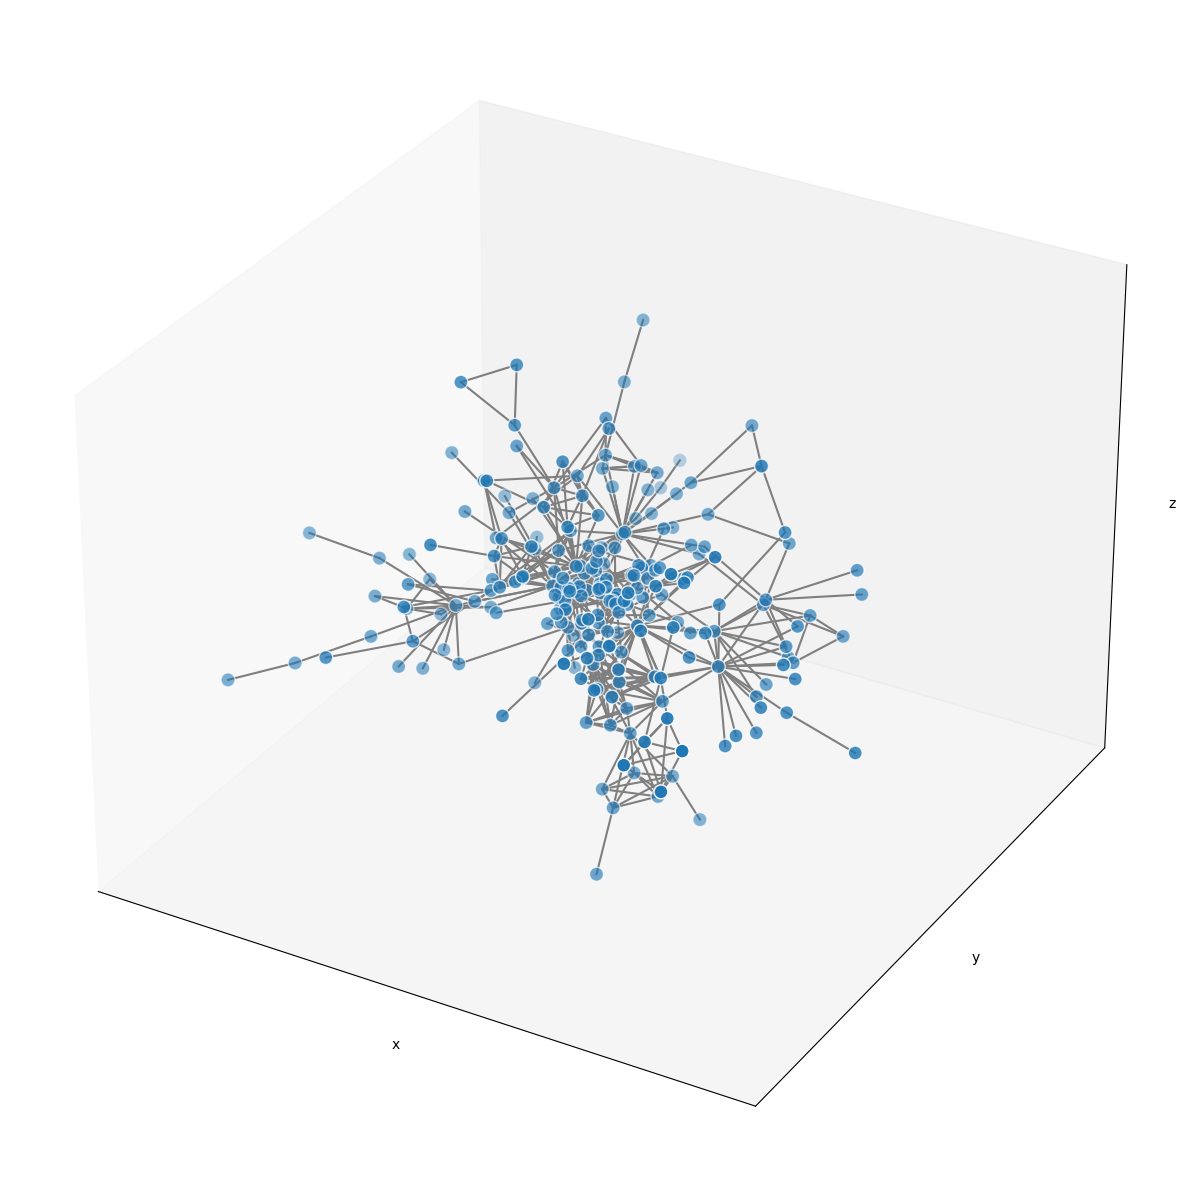

In [38]:
pos = nx.kamada_kawai_layout(G, dim=3)

node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(*node_xyz.T, s=100, ec="w")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    ax.grid(False)

    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

## Training Model ##

In [40]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [149]:
LR = 1e-04
HIDDEN = 32
EPOCHS = 500

In [151]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes)
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [153]:
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNConv: 1-1                           32
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       9,600
├─GCNConv: 1-2                           10
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       320
Total params: 9,962
Trainable params: 9,962
Non-trainable params: 0

In [155]:
def train():
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)

    if isinstance(criterion, nn.MSELoss):
        target = data.y[data.train_mask].float()
    else:
        target = data.y[data.train_mask]

    loss = criterion(out[data.train_mask], target)
    loss.backward()
    optimizer.step()

    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        true = data.y
        test_accuracy = (pred[data.test_mask] == true[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [157]:
start_time = time.time()

for epoch in range(EPOCHS):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {100*test_acc:.2f}%")

print("\nTraining Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch: 0, Loss: 2.3074, Test Accuracy: 12.13%
Epoch: 10, Loss: 2.2923, Test Accuracy: 14.43%
Epoch: 20, Loss: 2.2783, Test Accuracy: 16.57%
Epoch: 30, Loss: 2.2654, Test Accuracy: 17.85%
Epoch: 40, Loss: 2.2532, Test Accuracy: 22.29%
Epoch: 50, Loss: 2.2416, Test Accuracy: 31.60%
Epoch: 60, Loss: 2.2303, Test Accuracy: 35.95%
Epoch: 70, Loss: 2.2189, Test Accuracy: 37.49%
Epoch: 80, Loss: 2.2073, Test Accuracy: 37.75%
Epoch: 90, Loss: 2.1955, Test Accuracy: 39.28%
Epoch: 100, Loss: 2.1836, Test Accuracy: 39.88%
Epoch: 110, Loss: 2.1716, Test Accuracy: 41.42%
Epoch: 120, Loss: 2.1596, Test Accuracy: 42.87%
Epoch: 130, Loss: 2.1477, Test Accuracy: 43.81%
Epoch: 140, Loss: 2.1356, Test Accuracy: 45.60%
Epoch: 150, Loss: 2.1234, Test Accuracy: 46.37%
Epoch: 160, Loss: 2.1110, Test Accuracy: 47.99%
Epoch: 170, Loss: 2.0987, Test Accuracy: 50.30%
Epoch: 180, Loss: 2.0867, Test Accuracy: 51.58%
Epoch: 190, Loss: 2.0748, Test Accuracy: 52.09%
Epoch: 200, Loss: 2.0631, Test Accuracy: 52.95%
Epo

## Post-Training Analysis ##

In [159]:
embeddings = []

def hook(module, input, output):
    embeddings.append(output.detach().cpu())

model.conv2.register_forward_hook(hook)

model.eval()
out = model(data.x, data.edge_index)

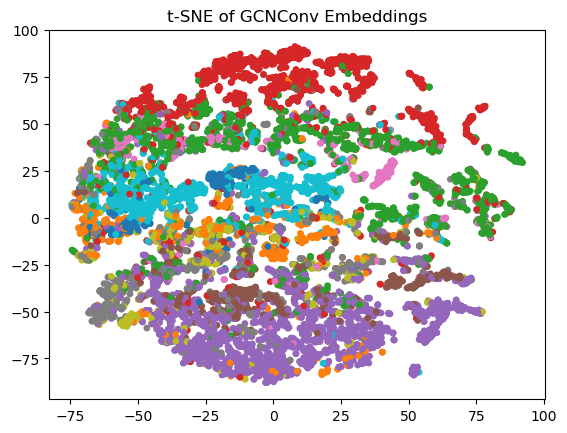

In [161]:
z = TSNE(n_components=2).fit_transform(embeddings[0].numpy())
plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

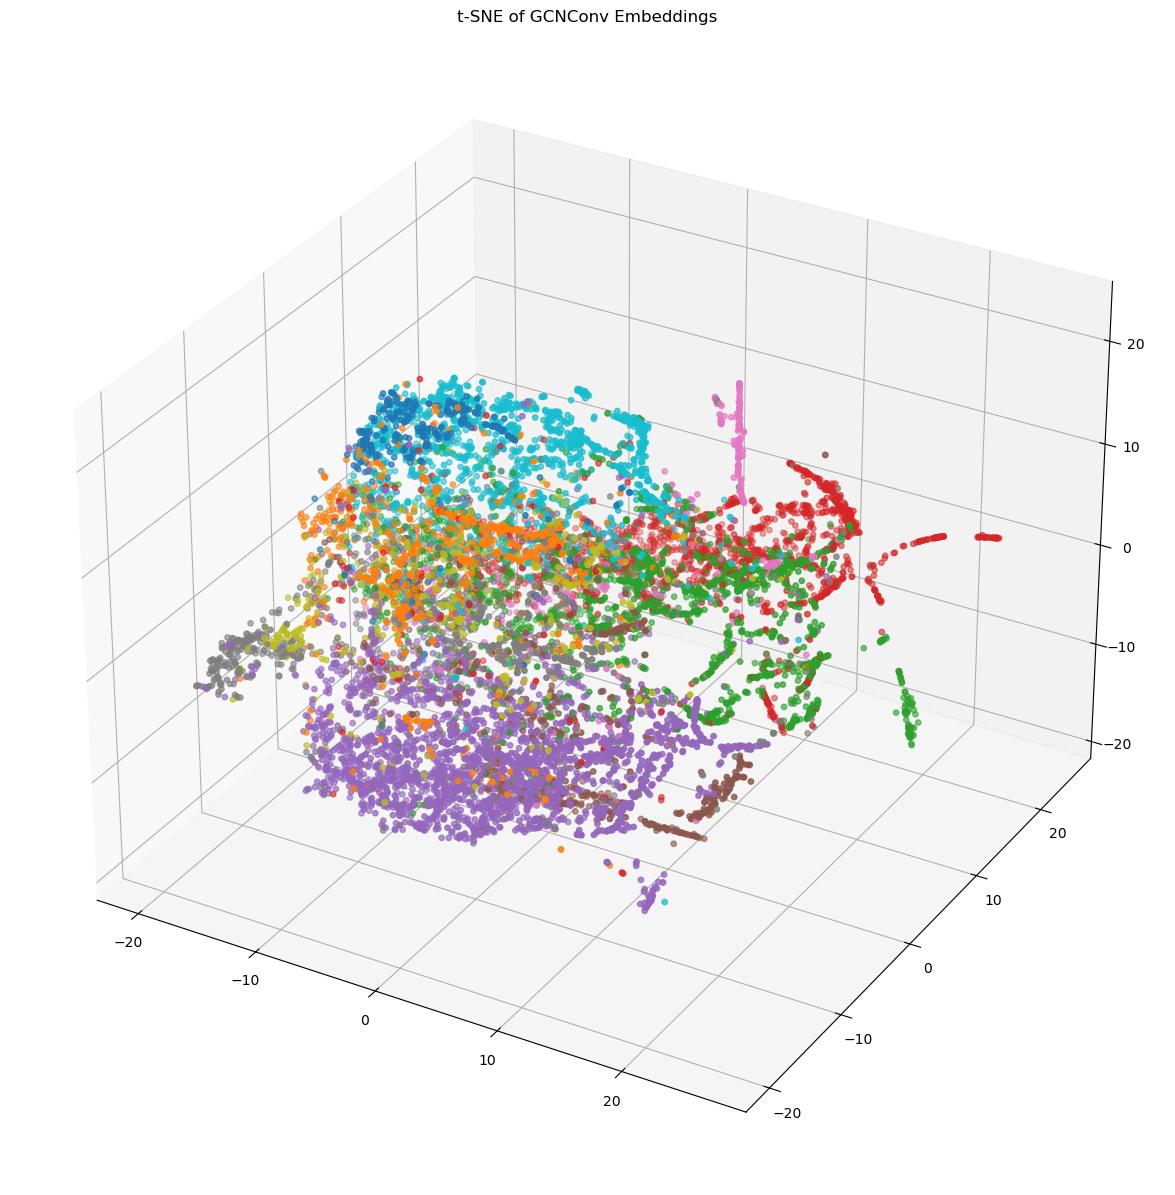

In [162]:
z = TSNE(n_components=3).fit_transform(embeddings[0].numpy())

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

In [163]:
probs = F.softmax(out, dim=1)
confidence, pred_class = probs.max(dim=1)

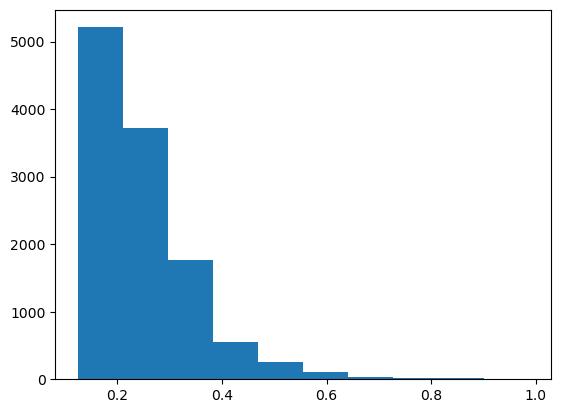

In [164]:
plt.hist(confidence.detach().numpy())
plt.show()

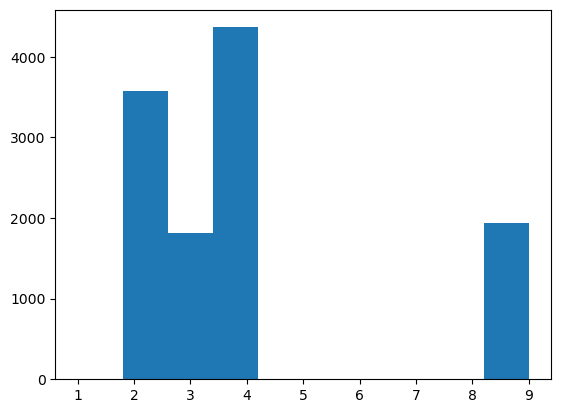

In [165]:
plt.hist(pred_class)
plt.show()

In [166]:
wrong = (pred_class != data.y).cpu()
wrong_nodes = torch.nonzero(wrong).flatten()

print(f"Number of Misclassified Nodes: {len(wrong_nodes.tolist())}")

Number of Misclassified Nodes: 4687


In [167]:
torch.save(model.state_dict(), "Wikipedia.pth")

In [177]:
loaded_model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes).to(device)
loaded_model.load_state_dict(torch.load("Wikipedia.pth"))
loaded_model.eval()

GCN(
  (conv1): GCNConv(300, 32)
  (conv2): GCNConv(32, 10)
)